# Week 6 Discussion: Logistic Regression

*Camelia Simoiu, Jongbin Jung, and Jerry Lin.*

In [1]:
set.seed(125)
library("IRdisplay")
library("tidyverse")
library("ggplot2")
theme_set(theme_bw())
options(repr.plot.width=5, repr.plot.height=4.5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


<a name="myfootnote1_back"></a>
## Setup

### Background

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband. 

In New York City, between 2003 and 2013, over 100,000 stops were made per year, with 685,724 people being stopped at the height of the program in 2011. The vast majority of those stopped were African-American or Latino, raising concerns of racial bias <sup>[1](#myfootnote1)</sup>.

We will work with a sample of stops in NYC made between 2008-2011, recorded on a [UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/).
The data can be downloaded as an `Rdata` file from [here](https://5harad.com/mse125/discussions/week_6/frisk_stops.RData).
Once you've downloaded the data, you can load it into your environment with the
`load()` function. This will load a single data frame named `stops`

In [2]:
# Read the data, downloaded from
# https://5harad.com/mse125/discussions/week_6/frisk_stops.RData
load("frisk_stops.RData")

# preview the first few rows of the data
head(stops)

id,date,time,precinct,suspect_race,suspect_sex,suspect_age,suspected_crime,frisked,found_weapon
<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,<lgl>,<lgl>
2686798,2010-12-17,15:15,83,hispanic,male,12,burglary,TRUE,FALSE
2075967,2009-12-08,15:19,40,black,male,19,cpw,TRUE,TRUE
1268296,2008-07-12,14:45,13,black,male,47,grand larceny,FALSE,FALSE
2522700,2010-09-08,21:55,43,black,male,23,cpw,TRUE,FALSE
2722653,2011-01-13,23:28,120,black,male,30,robbery,TRUE,FALSE
2333983,2010-05-12,19:55,62,white,male,24,grand larceny auto,TRUE,FALSE


For the purpose of this exercise, we will focus on a few selected columns:

* Base information regarding stop
    + `id`, `date`, `time`, `precinct`, `suspected_crime`
* Suspect demographics:
    + `suspect_sex`, `suspect_race`, `suspect_age`
* Was person frisked?
    + `frisked`
* Was a weapon found?
    + `found_weapon`



### Questions

We'll use the `stops` data to explore two questions.

1. Is there evidence of racial bias in the officer's decision to frisk individuals?

2. Can we design a better, statistically driven frisk policy?


## Question 1: Racial bias

First, we would like to better understand whether officiers' decision to
frisk individuals, after stopping them, may stem in part from racial bias.


### Base rate disparities in the decision to frisk

A natural first step in investigating racial bias is to look at
how often individuals of different race groups were frisked, given that they
are stopped.
In other words, for each race group among people who were stopped, we would like
to find the proportion of individuals who were frisked.

In [3]:
# Your code here!

# For each race, calculate
# num_stops: number of stops
# num_frisked: number of frisks, 
# p_frisked: probabiilty of being frisked

# START solution

p_frisk_by_race <- stops %>%
    group_by(suspect_race) %>%
    summarize(
        num_stops = n(),
        num_frisked = sum(frisked),
        p_frisked = mean(frisked)
    )  # this is equal to num_frisked / num_stops since "frisked" is binary
p_frisk_by_race

# END solution

suspect_race,num_stops,num_frisked,p_frisked
<fct>,<int>,<int>,<dbl>
black,54806,40542,0.7397365
hispanic,32512,23365,0.7186577
white,12682,7299,0.5755401


When comparing proportions across groups, is is common to compute the odds ratio (more on why that is later).
To compute odds ratios, we must first compute the odds, where for some
probability $p = \Pr(Y = 1)$, the odds of $Y = 1$ is computed as
$\frac{p}{1-p}$. In other words, the odds of some event is the probability of
the event happening, over the probability of the event _not_ happening.
For our example of frisk rates by race group, the odds would be computed as:

In [4]:
frisk_odds_by_race <- p_frisk_by_race %>%
  mutate(
      odds_of_frisk = p_frisked / (1 - p_frisked)
  ) %>%
  select(suspect_race, odds_of_frisk) 

display(frisk_odds_by_race)

# we then pivot pivot the tibble to a horizontal one for convenience
frisk_odds_by_race <- frisk_odds_by_race %>% 
    pivot_wider(names_from=suspect_race, values_from=odds_of_frisk)

frisk_odds_by_race

suspect_race,odds_of_frisk
<fct>,<dbl>
black,2.842260
hispanic,2.554389
white,1.355935


black,hispanic,white
<dbl>,<dbl>,<dbl>
2.84226,2.554389,1.355935


Then, the _odds ratio_ between two groups is computed as

$$\frac{\textrm{Odds for comparison group}}{\textrm{Odds for base group}}$$

For example, from the odds of frisk computed above, the odds ratio of a black
individual being frisked compared to a white individual is


In [5]:
# calcultae odds ratio
frisk_odds_by_race %>%
  transmute(odds_ratio = black / white)

odds_ratio
<dbl>
2.096162


Or equivalently, the odds ratio of a white individual being frisked compared
to a black individual is

In [6]:
frisk_odds_by_race %>%
  transmute(odds_ratio = white / black)

odds_ratio
<dbl>
0.4770624


Either way, we see that, on average, minorities are frisked at higher rates than whites.
However, as we will explore further, this is not enough evidence to conclude that officers' decision 
to frisk individuals is racially biased.


### Omitted variable bias

One concern is that officers might have a legitimate reason to frisk certain
individuals more often than others, and this legitimate reason is correlated with race.
Then, our previous measure would be biased due to that legitimate reason not
being captured in the data, which might otherwise explain the observed disparities.
This is known as omitted-variable bias.

For example, one of the reasons for stopping an individual is if the officer
suspects criminal posession of a weapon (CPW; encoded in the `stops` data as
`suspected_crime = "cpw"`). If this is the case, then one could argue that 
it is reasonable for an officer to frisk individuals whom
they have stopped under suspicion of criminal possession of weapons.
It just may be that certain race groups are more often suspected of CPW than other
race groups.

Let's see whether this is the case. 
To do so, we first need to create a new data frame that has a column indicating whether the stop was
for suspected criminal posession of a weapon

In [7]:
# Your code here!

# Create a new data frame that has a binary column indicating whether the stop was
# for suspected criminal posession of a weapon

# START solution

stops_cpw <- stops %>%
  mutate(is_cpw = suspected_crime == "cpw")

stops_cpw %>%
  group_by(suspect_race) %>%
  summarize(p_cpw = mean(is_cpw))

# END solution

suspect_race,p_cpw
<fct>,<dbl>
black,0.3540488
hispanic,0.2522453
white,0.1168585


Indeed, we find that minority race groups are stopped under suspicion of CPW
more often than whites.
When comparing frisk rates across race groups, we can account for the
differences in suspicion of CPW by first computing the proportion frisked for
each race group, conditional on whether the stop was under suspicion of CPW. 

In [8]:
# Your code here!

# Calculate proportion frisked for each race, accounting for cpw.
# We will do this by averaging the frisked proportion for cpw == TRUE and cpw == FALSE
# for each race

# START solution

# calculate the proportion frisked for each race, cpw status (3 races x 2 cpw statuses = 6 groups)
frisked_cpw <- stops_cpw %>%
  group_by(suspect_race, is_cpw) %>%
  summarise(num_stops   = n(),
            num_frisked = sum(frisked),
            p_frisked   = mean(frisked))

# calculate proportion frisked for each race, accounting for cpw
frisked_cpw %>% 
  group_by(suspect_race) %>%
  summarise(p_frisked = mean(p_frisked))

# END solution

suspect_race,p_frisked
<fct>,<dbl>
black,0.7862460
hispanic,0.7922402
white,0.7207532


We see that if we adjust for whether the stop reason was CPW, the disparities
decrease significantly, but do not disappear.


<a name="myfootnote2_back"></a>
### Base rate disparities with logistic regression

Adjusting for potentially legitimate factors, such as whether the stop was a CPW
stop, can get quite complex if we wish to adjust the frisk rate for more than
one variable.
Alternatively, we can use regression to measure the differences across race groups,
conditional on a number of covariates.
Specifically for the case where the outcome of interest is a binary variable
(e.g., whether or not an individual was frisked), a logistic regression is
often used.

In `R` we use the `glm` function to fit generalized regression models, such as
a logistic regression.
In its simplest form, the `glm` function is specified with a formula, the data,
and a family which indicates what type of "generalized" regression is used<sup>[2](#myfootnote2)</sup>.
A formula in `R` is specified in the form: `Left-hand-side variable ~ Right-hand-side specifications`.
In the simplest form of our example, we would like to

- regress `frisked` on the `suspect_race` variable (specifying the formula
  `frisked ~ suspect_race`)
- use a logistic link function (which is of the `binomial` family)
- using the `stops` data

Hence, we would write:

In [9]:
base_model <- glm(frisked ~ suspect_race,
                  family = binomial,
                  data = stops)
print(base_model)


Call:  glm(formula = frisked ~ suspect_race, family = binomial, data = stops)

Coefficients:
         (Intercept)  suspect_racehispanic     suspect_racewhite  
              1.0446               -0.1068               -0.7401  

Degrees of Freedom: 99999 Total (i.e. Null);  99997 Residual
Null Deviance:	    120100 
Residual Deviance: 118800 	AIC: 118800



In the model above, we see that the model coefficients are relative to 
the `suspect_race = "black"` group (i.e., there is no `suspect_raceblack`
coefficient).
We see that Hispanic and white individuals are less likely 
to be frisked than blacks (as indicated by the negative coefficient).

This is because the `"black"` category happens to be the first in alphabetical
order of all the values that `suspect_race` takes, hence it is
made the base group by default.

However, in an analysis of disparities such as this, it is often useful to
set the majority group (`suspect_race = "white"`) as the base group,
so that each coefficient indicates the comparison of a minority group versus
the majority group.




#### Setting the base group


This can be achieved by manually manipulating the order of factor levels.
Recall that a `factor` is how `R` efficiently stores categorical variables.
We can use the `factor` function to create a factor, and use the `levels` function
to inspect what levels exist in a factor variable.

In [10]:
levels(stops$suspect_race)

[1] "black"    "hispanic" "white"

To change the first `level` of a `factor` variable, we can use the `relevel` function

In [11]:
stops <- stops %>%
  mutate(suspect_race = relevel(stops$suspect_race, "white"))
levels(stops$suspect_race)

[1] "white"    "black"    "hispanic"

We can now refit the `base_model` so that the `suspect_race = "white"` group
is the base group


In [12]:
base_model <- glm(frisked ~ suspect_race,
                  data = stops,
                  family = binomial)
print(base_model)


Call:  glm(formula = frisked ~ suspect_race, family = binomial, data = stops)

Coefficients:
         (Intercept)     suspect_raceblack  suspect_racehispanic  
              0.3045                0.7401                0.6333  

Degrees of Freedom: 99999 Total (i.e. Null);  99997 Residual
Null Deviance:	    120100 
Residual Deviance: 118800 	AIC: 118800


## Interpretation of logistic coefficients

We can inspect the coefficients of the fitted model using the `coef` function

In [13]:
coef(base_model)

(Intercept)    suspect_raceblack suspect_racehispanic 
           0.3044915            0.7401081            0.6333217

The coefficient returned by a logistic regression in R is a logit, or the log of the odds.
This is usually called "log-odds" for short.

If p is a probability, then p/(1 − p) is the corresponding odds; the logit of the probability is the (natural) logarithm of the odds, i.e.


$$
\mbox{logit}(p) = \mbox{log}(\frac{p}{1-p})
$$

For categorical variables, this represents the change in log-odds for a
specific group (level), compared to the base group.

Taking the exponential of the coefficients, we can
find the odds ratio of each covariate compared to the base group.

In [14]:
exp(coef(base_model))

(Intercept)    suspect_raceblack suspect_racehispanic 
            1.355935             2.096162             1.883858


Notice that in this model, the base group is `suspect_race = "white"`, and the
exponential of the `suspect_raceblack` coefficient is equivalent to the odds
ratio of being frisked for black individuals compared to white individuals,
which we computed earlier.



### Adjusting for multiple variables

Now that we can fit a logistic regression to measure (log) odds ratios across different race groups,
adjusting our estimate for various covariates is as simple as adding those covariates in our regression function.
For example, if we wanted to adjust for `suspected_crime` (which includes `cpw`), we would simply fit the following model:

In [15]:
model <- glm(frisked ~ suspect_race + suspected_crime,
             data = stops, family = binomial)

# Inspect coefficients for `suspect_race` covariates
# "broom" is a a useful way to look at coefficients 
broom::tidy(model) %>%
  filter(grepl("suspect_race", term)) %>%
  transmute(term, odds_ratio = exp(estimate))

term,odds_ratio
<chr>,<dbl>
suspect_raceblack,1.300687
suspect_racehispanic,1.405759


We can see that, even adjusting for `suspected_crime`, black individuals are

In [16]:
format(exp(coef(model)[["suspect_raceblack"]]), digits = 3)

[1] "1.3"

times more likely
to be frisked than white individuals.

Of course, using a logistic regression, we can adjust for many more potentially legitimate
covariates. It might make sense to further adjust for location (`precinct`) and other demographic
information (`suspect_age` and `suspect_sex`).

In [17]:
# Your code here!

# Fit a logistic regression model while adjusting for
# suspect_race, suspected_crime, precinct, suspect_age, and suspect_sex

# START solution

model <- glm(frisked ~ suspect_race + suspected_crime + precinct + suspect_age + suspect_sex,
             data = stops, family = binomial)

# END solution

In [18]:
# Look at coefficients for `suspect_race` covariates
# "broom" is a a useful way to look at coefficients 
broom::tidy(model) %>%
  filter(grepl("suspect_race", term)) %>%
  transmute(term, odds_ratio = exp(estimate))

term,odds_ratio
<chr>,<dbl>
suspect_raceblack,1.265826
suspect_racehispanic,1.179532


But even after adjusting for all these covariates, we still find that black
individuals are


In [19]:
format(exp(coef(model)[["suspect_raceblack"]]), digits = 3)

[1] "1.27"

times more likely to be frisked than white individuals.


### Contrasting probability and odds scales

To better understand why it makes sense to use the odds ratio instead of
probability, let's create a synthetic dataset of individuals. We will create
this new dataset by choosing two individuals from the `stops` data, and creating
copies of them, one with `suspect_race = "white"` and the other with
`suspect_race = "black"`.

In [20]:
sample_individuals <- stops %>%
  sample_n(2)

fake_data <- bind_rows(
    sample_individuals %>%
      mutate(suspect_race = "white"),
    sample_individuals %>%
      mutate(suspect_race = "black")
)
fake_data 

id,date,time,precinct,suspect_race,suspect_sex,suspect_age,suspected_crime,frisked,found_weapon
<int>,<chr>,<chr>,<fct>,<chr>,<fct>,<int>,<fct>,<lgl>,<lgl>
1596054,2009-02-10,12:52,81,white,male,17,robbery,TRUE,FALSE
1767747,2009-05-14,22:40,10,white,male,32,criminal sale of controlled substance,TRUE,TRUE
1596054,2009-02-10,12:52,81,black,male,17,robbery,TRUE,FALSE
1767747,2009-05-14,22:40,10,black,male,32,criminal sale of controlled substance,TRUE,TRUE



Now, we will use our model from before to generate "predictions" of whether each individual will be frisked.
Then, for each of the two initial samples, we have estimates for the probability of being frisked
if `suspect_race = "black"` versus if `suspect_race = "white"`.

In [21]:
predicted_probs <- fake_data %>%
  mutate(p_frisk = predict(model, fake_data, type = "response")) %>%
  select(id, suspect_race, p_frisk)

predicted_probs

id,suspect_race,p_frisk
<int>,<chr>,<dbl>
1596054,white,0.8660031
1767747,white,0.4282061
1596054,black,0.8910777
1767747,black,0.4866409


In [22]:
# reshape predicted_probs for convenience
predicted_probs_wider <- predicted_probs %>%
    pivot_wider(names_from = suspect_race, values_from = p_frisk)

predicted_probs_wider

id,white,black
<int>,<dbl>,<dbl>
1596054,0.8660031,0.8910777
1767747,0.4282061,0.4866409


Notice that if we were to compare the difference in probability among the two
cases across different race groups, we would have a different estimate, _even
though in both cases, the only thing that has changed is_ `suspect_race`.

In [23]:
predicted_probs_wider %>%
  mutate(probability_difference = black - white)

id,white,black,probability_difference
<int>,<dbl>,<dbl>,<dbl>
1596054,0.8660031,0.8910777,0.02507459
1767747,0.4282061,0.4866409,0.05843481


However, if we compare the odds ratio for black versus white for the two cases,
we will find that it is equal, and exactly the exponential of the
`suspect_raceblack` coefficient from the `model`:

In [24]:
predicted_probs_wider %>%
  mutate(
      odds_black = black / (1 - black),
      odds_white = white / (1 - white), 
      odds_ratio = odds_black / odds_white
  )

id,white,black,odds_black,odds_white,odds_ratio
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1596054,0.8660031,0.8910777,8.1808557,6.4628594,1.265826
1767747,0.4282061,0.4866409,0.9479541,0.7488818,1.265826


In [25]:
# suspect_raceblack coefficient from our model
format(exp(coef(model)[["suspect_raceblack"]]), digits = 3)

[1] "1.27"


## Question 2: Designing policies

We now turn to our second question: can we use data to build a
statistically driven frisk policy?
Such a policy can often be constructed in the following two steps:

1. Fit a statistical model to estimate _risk_
1. Set a threshold at which the decision is made.

For the example of deciding whether or not to frisk individuals who have 
been stopped, the _risk_ is the probability that a weapon is recovered
if we were to frisk the individual.
We would like to frisk only the individuals that are most likely to carry a weapon.
Then the policy would be to frisk individuals whose estimated probability of
carrying a weapon is greater than some pre-selected value that we consider optimal.

<!-- [TODO: we want to frisk the highest likely people to have, we frisk those whose probabilit is  > cost ] -->

We will take a closer look at each of these steps below.


### Estimating risk

The only legal reason for an officer to conduct a frisk is for officer
safety. In other words, the only justified goal of a frisk is to recover
weapons.
For an individual $i$, let $X_i$ be all the information we know about the
individual prior to making the frisk decision, and define


$$
Y_i =
\begin{cases}
1 & \textrm{if weapon is found on individual } i \\
0 & \textrm{otherwise}
\end{cases}
$$


Then, the _risk_ we are interested in measuring can be written as

$$
r_i = \Pr(Y_i = 1 ~|~ X_i)
$$



In other words, we wish to estimate the probability that we will recover a 
weapon from an individual, characterized by covariates $X_i$, if we were to 
frisk them.

One way to estimate this probability is to fit a logistic regression on the
subset of individuals who were frisked, to predict whether a weapon will be
found, using all the covariates that an officer observed prior to conducting the
frisk. 


In [26]:
frisked_df <- stops %>% 
  filter(frisked == TRUE)
  
risk_model <- glm(found_weapon ~ suspect_sex + suspect_age + suspected_crime + precinct, 
                  data = frisked_df,
                  family = binomial)

Once we have the risk model, we can generate predictions for the full population 
of data:

In [27]:
stops <- stops %>% 
  mutate(risk = predict(risk_model, stops, type = "response"))

head(stops)

id,date,time,precinct,suspect_race,suspect_sex,suspect_age,suspected_crime,frisked,found_weapon,risk
<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,<lgl>,<lgl>,<dbl>
2686798,2010-12-17,15:15,83,hispanic,male,12,burglary,TRUE,FALSE,0.007787479
2075967,2009-12-08,15:19,40,black,male,19,cpw,TRUE,TRUE,0.030162829
1268296,2008-07-12,14:45,13,black,male,47,grand larceny,FALSE,FALSE,0.020983237
2522700,2010-09-08,21:55,43,black,male,23,cpw,TRUE,FALSE,0.017451628
2722653,2011-01-13,23:28,120,black,male,30,robbery,TRUE,FALSE,0.005656276
2333983,2010-05-12,19:55,62,white,male,24,grand larceny auto,TRUE,FALSE,0.033206244



### Finding an optimal threshold

Given risk estimates, we can now propose a policy by setting a threshold on 
the predicted probability of finding a weapon.
Finding an optimal threshold, however, will depend largely on the various 
cost/benefits associated with a frisk.

One thing to consider when determining an optimal threshold, for example, 
might be the proportion of weapons that are recovered, as a function 
of how many people are frisked.

From a technical point-of-view, we can compute and plot this trade-off by first
sorting our data frame in decreasing order of the estimated risk. Then, compute
a running tally of the proportion of stopped individuals who are frisked (i.e.,
higher risk individuals are frisked first), as well as the proportion of weapons
that are recovered.
A running tally, or cumulative sum, can be computed using the `cumsum` function.


In [28]:
# Your code here!

# Calculate 
# prop_frisk: proportion of people frisked by frisking k individuals
# num_weapons_found: number of total weaspons found by frisking the top k riskest individuals
# prop_weapons_found: proportion of total weaspons found by frisking the top k riskest individuals
# with k ranging from 1 to all people in the dataset

# START solution

stops <- stops %>%
  arrange(desc(risk)) %>%
  mutate(
    # n() is the number of rows in the data frame (i.e., the total nr of stops)
    k = 1:n(),    
    # We "frisk" the riskiest people first, i.e., from top to bottom
    prop_frisk = k / n(),  
    # calculate running sum of weapons found with each additional stop
    num_weapons_found = cumsum(found_weapon),   
    prop_weapons_found = num_weapons_found/sum(found_weapon)
  )


# END solution

id,risk,k,prop_frisk,found_weapon,num_weapons_found,prop_weapons_found
<int>,<dbl>,<int>,<dbl>,<lgl>,<int>,<dbl>
1514061,0.4835364,1,1e-05,FALSE,0,0.0000000000
1217202,0.4296577,2,2e-05,FALSE,0,0.0000000000
1811434,0.4239015,3,3e-05,FALSE,0,0.0000000000
1016518,0.4118351,4,4e-05,FALSE,0,0.0000000000
1315753,0.4086701,5,5e-05,TRUE,1,0.0004338395
1603699,0.4036302,6,6e-05,TRUE,2,0.0008676790
1216421,0.4036302,7,7e-05,TRUE,3,0.0013015184
2180742,0.4011178,8,8e-05,TRUE,4,0.0017353579
1657155,0.4011178,9,9e-05,TRUE,5,0.0021691974


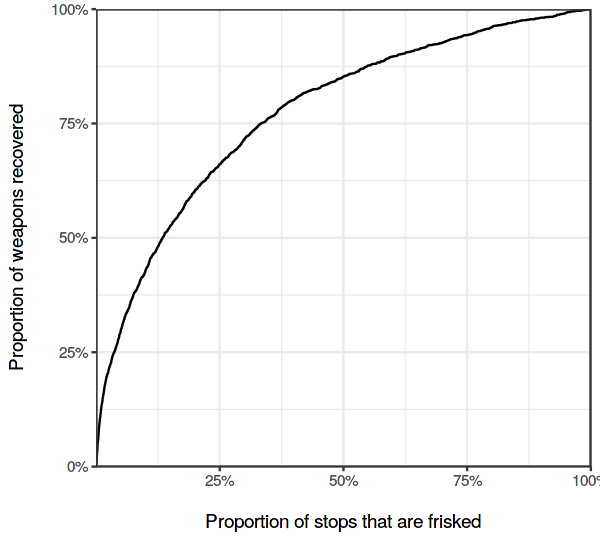

In [29]:
# let's inspect our newly created columns
head(stops %>%
       select(id, risk, k, prop_frisk, found_weapon, num_weapons_found, prop_weapons_found),
     n=10)

tradeoff_plot <- ggplot(stops, aes(x = prop_frisk, y = prop_weapons_found)) +
  geom_line() +
  scale_x_continuous("\nProportion of stops that are frisked",
                     labels = scales::percent_format(1),
                     expand = c(0, 0)) +
  scale_y_continuous("Proportion of weapons recovered\n",
                     labels = scales::percent_format(1),
                     expand = c(0, 0))
tradeoff_plot

Given this trade-off, we can now find the optimal policy based on various
cost/benefit constraints.
For example, if we were to require that at least 50% of all weapons must be recovered, 
while frisking as few people as possible, we could find the threshold to be the
lowest value of risk where we recover at least 50% of all weapons.

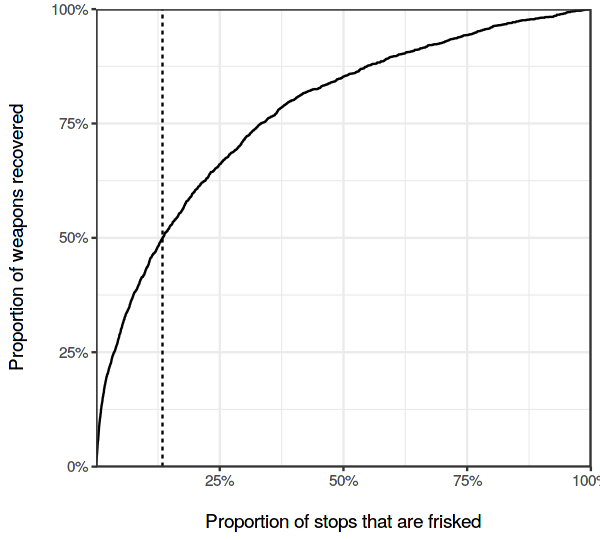

In [30]:
threshold <- stops %>% 
  filter(prop_weapons_found >= .5) %>% 
  arrange(desc(risk)) %>% 
  slice(1) 

tradeoff_plot +
  geom_vline(xintercept = threshold$prop_frisk,
             linetype = "dashed")

We can see that this is acheived by setting a threshold of

In [31]:
scales::percent(threshold$risk)

[1] "6%"

i.e., only frisk an individual if the predicted probability of recovering a weapon is greater than that.
And if we were to implement this policy, we expect about

In [32]:
scales::percent(threshold$prop_frisk)

[1] "13%"

of stopped individuals to be frisked as a result, compared to the current frisk rate of:

In [33]:
# Proportion of 
scales::percent(mean(stops$frisked))

[1] "71%"

### Footnote:

<a name="myfootnote1">1</a>. https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City &nbsp;&nbsp;&nbsp; [\[go back\]](#myfootnote1_back)

<a name="myfootnote2">2</a>. As usual, see `?glm` for details. &nbsp;&nbsp;&nbsp; [\[go back\]](#myfootnote2_back)